# Relationship to MUA
<p>Figures: schematic MUA, epoch-based linear regression of correlation with aperiodic parameters, temporal correlation
<p>
<p>created: Septermber 18, 2024
<p>last modified: September 25, 2024


## Set-up

In [1]:
# auto-reload
%load_ext autoreload
%autoreload 2

In [21]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import zscore

# custom
import sys
sys.path.append("../../code")
from paths import EXTERNAL_PATH
from info import SESSIONS, FS, TOTAL_CHANS, EPOCH_TIMES
from plots import plot_schematic, plot_regression
from utils import compute_confidence_interval, subtract_baseline

### Settings

In [22]:
# set plotting style
plt.style.use('../../mpl_styles/sfn_2024.mplstyle')

# choose seesion to visualize
session = SESSIONS[1]


### Create output directory

In [23]:
dir_out = f"{EXTERNAL_PATH}/figures/sfn_2024"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [24]:
# load MUA data
mua = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\mua_df.csv")
mua_pre = mua.loc[(mua['session'] == session) &
                (mua['epoch'] == 'pre'), 'mua']
mua_post = mua.loc[(mua['session'] == session) &
                (mua['epoch'] == 'post'), 'mua']
mua_diff = mua_post.values - mua_pre.values

mua

,Unnamed: 0,session,array,channel,epoch,mua
0,0,A_SNR_041018,1,0,pre,4.327240
1,1,A_SNR_041018,1,1,pre,4.336008
2,2,A_SNR_041018,1,2,pre,4.323233
3,3,A_SNR_041018,1,3,pre,4.523598
4,4,A_SNR_041018,1,4,pre,3.497945
...,...,...,...,...,...,...
6139,6139,L_SNR_250717,16,59,post,5.921929
6140,6140,L_SNR_250717,16,60,post,5.528276
6141,6141,L_SNR_250717,16,61,post,5.299164
6142,6142,L_SNR_250717,16,62,post,4.856267


In [25]:
# load spectral parameters and merge with mua
params = pd.read_csv(fR"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
df = pd.merge(params, mua, on=['session', 'array', 'epoch', 'channel'])
df

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,...,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared,Unnamed: 0,mua
0,A_SNR_140819,0,0,1,pre,5.774364,-6.789797,2.264008,9.805430,0.663349,...,17.365468,0.618030,10.053661,60.675713,0.575678,2.164377,0.064003,0.994617,2048,1.905090
1,A_SNR_140819,1,1,1,pre,6.041152,4.586532,2.449866,NaN,NaN,...,16.674368,0.648848,12.000000,60.706228,0.607547,2.080446,0.075752,0.991611,2049,1.966392
2,A_SNR_140819,2,2,1,pre,5.513418,-3.240593,1.956623,10.471750,0.483946,...,17.742891,0.396295,12.000000,60.127900,0.400871,2.001077,0.065324,0.990826,2050,2.518872
3,A_SNR_140819,3,3,1,pre,6.029085,7.909415,2.459045,NaN,NaN,...,17.123952,0.615339,12.000000,60.970030,0.667564,2.000000,0.074475,0.991993,2051,2.025281
4,A_SNR_140819,4,4,1,pre,5.998930,7.405537,2.411469,NaN,NaN,...,17.093011,0.599103,12.000000,60.682388,0.671076,2.228288,0.071394,0.992443,2052,2.039145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,...,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753,6139,5.921929
4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,...,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501,6140,5.528276
4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,...,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839,6141,5.299164
4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,...,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195,6142,4.856267


In [26]:
# load time-resolved parameters and MUA, and pre-process for plotting
data_mua = pd.read_csv(f"{EXTERNAL_PATH}/data/results/lfp_stm_params_mua.csv")
session_df_mua = data_mua[data_mua.get('session') == SESSIONS[0]].loc[((data_mua['window']>124) & (data_mua['window']<375))]
session_df_mua['time'] = (session_df_mua.get('window')/FS) + EPOCH_TIMES[0]

vars = ['offset', 'exponent', 'mua']
ci = {'lci_offset':[], 'rci_offset':[], 'lci_exponent':[], 'rci_exponent':[], 'lci_mua':[], 'rci_mua':[]}

for var in vars:
    print(f'starting var : {var}')
    count = 0
    z_vars = np.array([])

    for i in range(TOTAL_CHANS):
        # channel zscore values
        data_a = session_df_mua.iloc[np.arange(count, count + 250)]

        z_var = zscore(data_a[var], nan_policy='omit')
        z_vars = np.append(z_vars, z_var)

        count = count + 250

    # add zscore and time variables to df
    session_df_mua[f"z_{var}"] = z_vars
    
    # subtract baseline
    print('subtracting baseline')
    session_df_mua[f'relative_{var}'] = subtract_baseline(session_df_mua.get(f'z_{var}'), session_df_mua.get('time'), np.array([session_df_mua.get('time').min(), 0]))

    # compute left and right endpoint confidence intervals
    lci_var = np.array([])
    rci_var = np.array([])

    for i in np.unique(session_df_mua.get('window')):
        window_df = session_df_mua[session_df_mua.get('window') == i]

        ci_var = compute_confidence_interval(window_df.get(f'relative_{var}'))
        ci[f'lci_{var}'].append(ci_var[0])
        ci[f'rci_{var}'].append(ci_var[1])
        
# average components per window
session_df_mua = session_df_mua.groupby('window').mean().reset_index()
session_df_mua

starting var : offset
subtracting baseline
starting var : exponent
subtracting baseline
starting var : mua
subtracting baseline


,window,Unnamed: 0,channel,chan_idx,array,event,offset,knee,exponent,alpha_cf,...,error,r_squared,mua,time,z_offset,relative_offset,z_exponent,relative_exponent,z_mua,relative_mua
0,125,767875.0,31.5,511.5,8.5,511.5,7.596899,8709.303412,3.228449,15.378632,...,0.066616,0.989395,3.151260,-0.050,-0.682234,-0.270934,-0.440505,-0.050016,-0.548006,-0.070662
1,126,767876.0,31.5,511.5,8.5,511.5,7.542358,5791.478689,3.189942,14.792353,...,0.066974,0.989027,3.167691,-0.048,-0.865093,-0.453793,-0.672749,-0.282259,-0.450841,0.026504
2,127,767877.0,31.5,511.5,8.5,511.5,7.481829,4539.442848,3.146883,14.702384,...,0.065903,0.989107,3.164589,-0.046,-1.068587,-0.657287,-0.918227,-0.527738,-0.497563,-0.020219
3,128,767878.0,31.5,511.5,8.5,511.5,7.464980,5090.331295,3.130068,14.839397,...,0.065495,0.989105,3.155235,-0.044,-1.095119,-0.683819,-0.980135,-0.589645,-0.535463,-0.058119
4,129,767879.0,31.5,511.5,8.5,511.5,7.518607,6772.582060,3.155438,15.216449,...,0.067584,0.988583,3.158264,-0.042,-0.924244,-0.512944,-0.828403,-0.437913,-0.403415,0.073930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,370,768120.0,31.5,511.5,8.5,511.5,7.861398,21410.294126,3.369031,13.957704,...,0.070334,0.987886,3.175091,0.440,0.318720,0.730020,0.464041,0.854531,-0.068038,0.409306
246,371,768121.0,31.5,511.5,8.5,511.5,7.873827,22249.250259,3.376438,13.934898,...,0.070660,0.987799,3.159664,0.442,0.352804,0.764104,0.498477,0.888967,-0.345392,0.131952
247,372,768122.0,31.5,511.5,8.5,511.5,7.890120,22855.519925,3.386145,13.928538,...,0.070415,0.987843,3.153517,0.444,0.398639,0.809939,0.546275,0.936765,-0.440936,0.036408
248,373,768123.0,31.5,511.5,8.5,511.5,7.886662,22217.251842,3.383587,13.956077,...,0.070018,0.987904,3.155613,0.446,0.391457,0.802757,0.536650,0.927140,-0.248389,0.228955


## Main

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)


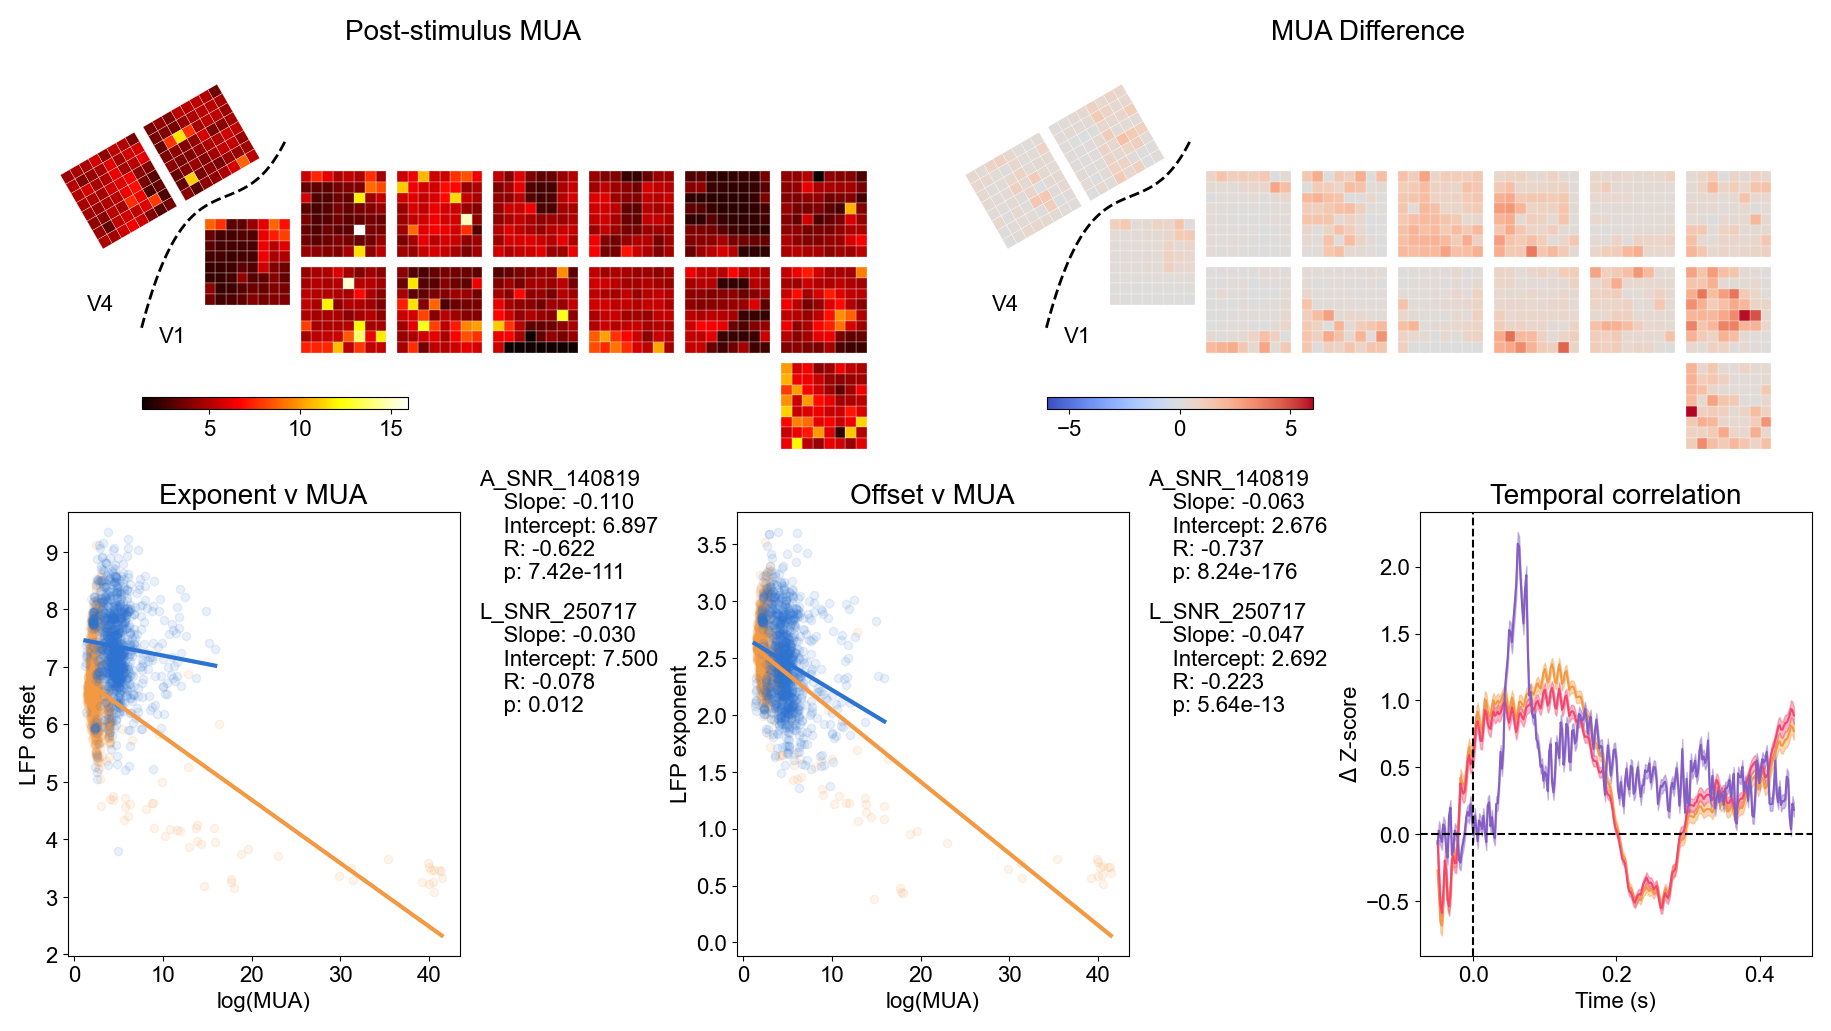

In [27]:
# create figure and gridspec
fig = plt.figure(figsize=[18, 10], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], 
                         height_ratios=[3/4,1])

# create subplots (first row)
ax_a = fig.add_subplot(spec[0,0])
ax_b = fig.add_subplot(spec[0,1])

# create nested gridspec in second row
spec_a = spec[1,:].subgridspec(ncols=3, nrows=1, width_ratios=[1,1,1])
ax_c = fig.add_subplot(spec_a[0,0])
ax_d = fig.add_subplot(spec_a[0,1])
ax_e = fig.add_subplot(spec_a[0,2])

# set PLACEHOLDER titles
ax_a.set_title("Post-stimulus MUA")
ax_b.set_title("MUA Difference")
ax_c.set_title("Exponent v MUA")
ax_d.set_title("Offset v MUA")
ax_e.set_title("Temporal correlation")

# plot subplot a-b: schematic on MUA -------------------------------------------
odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"
plot_schematic(mua_post, odml_path, ax=ax_a)
plot_schematic(mua_diff, odml_path, norm_type='centered', ax=ax_b)

# plot subplot c-d: epoch-based correlation ------------------------------------
for var, ax_lin in zip(['offset', 'exponent'], [ax_c, ax_d]):
    for (i_session, session), c in zip(enumerate(SESSIONS),  ['#F39943', '#2C73D2']):
        x_data = df.loc[(df['session']==session) & (df['epoch']=='post'), 'mua']
        y_data = df.loc[(df['session']==session) & (df['epoch']=='post'), var]

        plot_regression(x_data, y_data, ax=ax_lin, xlabel='log(MUA)', 
                        ylabel=f'LFP {var}',color=c, label=session, 
                        label_offset=0.3*i_session)

# plot subplot e: temporal correlation -----------------------------------------
ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_offset'), c='#F39943', label='offset')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_offset'), ci.get('rci_offset'), color='#F39943', alpha=0.4)

ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_exponent'), c='#F5466F', label='exponent')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_exponent'), ci.get('rci_exponent'),  color='#F5466F', alpha=0.4)

ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_mua'), c='#845EC2', label='mua')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_mua'), ci.get('rci_mua'),  color='#845EC2', alpha=0.4)
ax_e.set_xlabel('Time (s)')
ax_e.set_ylabel(r'$\Delta$ Z-score')
ax_e.axhline(y=0, color='k', linestyle='--')
ax_e.axvline(x=0, color='k', linestyle='--')

# save figure
plt.savefig(f'{dir_out}/panel_7.png')

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)


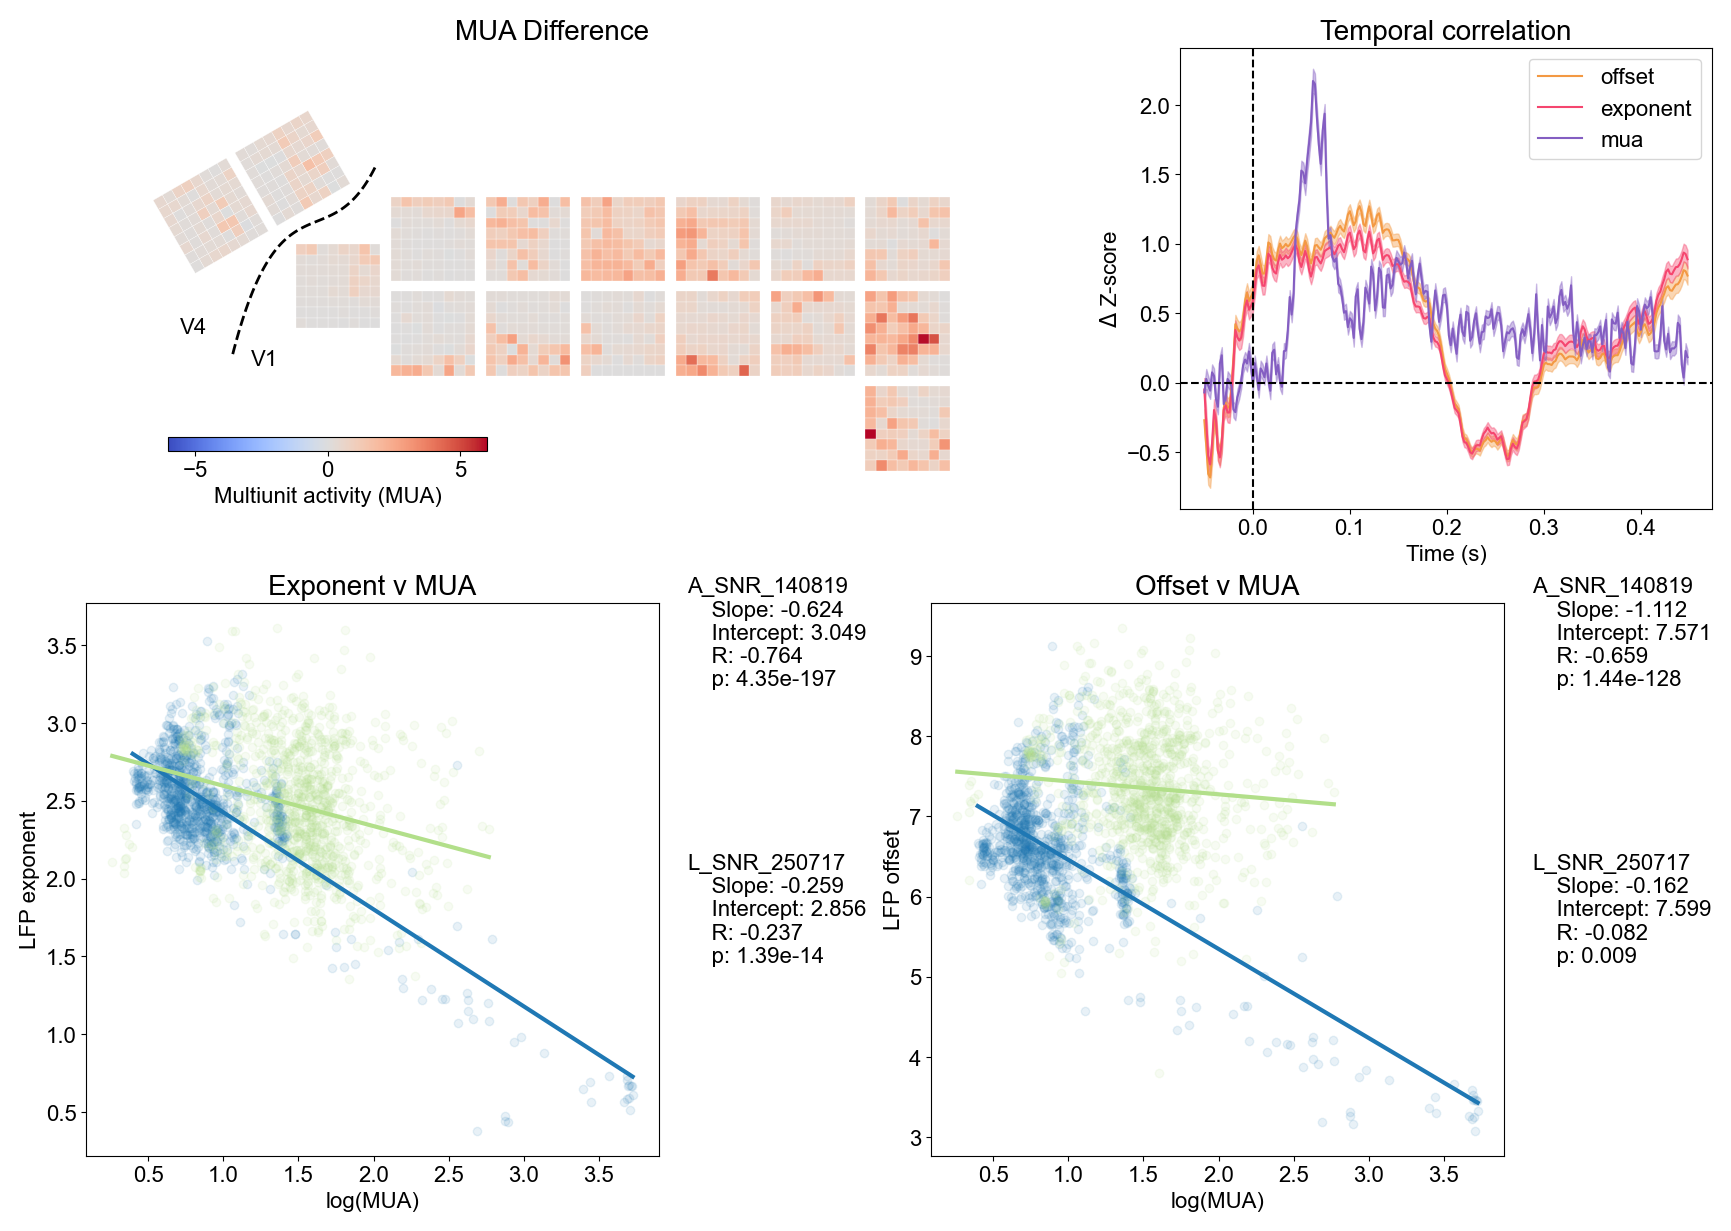

In [28]:
# create figure and gridspec
fig = plt.figure(figsize=[17, 12], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], 
                         height_ratios=[1, 1])

# create subplots
spec_a = spec[0,:].subgridspec(ncols=2, nrows=1, width_ratios=[2/3, 1/3])
ax_a = fig.add_subplot(spec_a[0,0])
ax_b = fig.add_subplot(spec_a[0,1])
ax_c = fig.add_subplot(spec[1,0])
ax_d = fig.add_subplot(spec[1,1])

# set titles
ax_a.set_title("MUA Difference")
ax_b.set_title("Temporal correlation")
ax_c.set_title("Exponent v MUA")
ax_d.set_title("Offset v MUA")

# plot subplot a: schematic difference
odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"
plot_schematic(mua_diff, odml_path, label='Multiunit activity (MUA)', norm_type='centered', ax=ax_a)

# plot subplot b: temporal correlation -----------------------------------------
(offset, ) = ax_b.plot(session_df_mua.get('time'), session_df_mua.get('relative_offset'), c='#F39943', label='offset')
ax_b.fill_between(session_df_mua.get('time'), ci.get('lci_offset'), ci.get('rci_offset'), color='#F39943', alpha=0.4)

(exponent, ) = ax_b.plot(session_df_mua.get('time'), session_df_mua.get('relative_exponent'), c='#F5466F', label='exponent')
ax_b.fill_between(session_df_mua.get('time'), ci.get('lci_exponent'), ci.get('rci_exponent'),  color='#F5466F', alpha=0.4)

(mua, ) = ax_b.plot(session_df_mua.get('time'), session_df_mua.get('relative_mua'), c='#845EC2', label='mua')
ax_b.fill_between(session_df_mua.get('time'), ci.get('lci_mua'), ci.get('rci_mua'),  color='#845EC2', alpha=0.4)
ax_b.legend(fancybox=True)
ax_b.set_xlabel('Time (s)')
ax_b.set_ylabel(r'$\Delta$ Z-score')
ax_b.axhline(y=0, color='k', linestyle='--')
ax_b.axvline(x=0, color='k', linestyle='--')

# plot subplot c-d: epoch-based correlation ------------------------------------
for var, ax_lin in zip(['exponent', 'offset'], [ax_c, ax_d]):
    for (i_session, session), c in zip(enumerate(SESSIONS),  ['#1f78b4', '#b2df8a']):
        x_data = df.loc[(df['session']==session) & (df['epoch']=='post'), 'mua']
        y_data = df.loc[(df['session']==session) & (df['epoch']=='post'), var]

        plot_regression(np.log(x_data), y_data, ax=ax_lin, xlabel='log(MUA)', 
                        ylabel=f'LFP {var}',color=c, label=session, 
                        label_offset=0.5*i_session)

# save figure
plt.savefig(f'{dir_out}/panel_7.2.png')
